In [1]:
import numpy as np
from figaro.mixture import DPGMM
from figaro.plot import plot_median_cr
from figaro.utils import get_priors
from figaro.load import save_density
from tqdm import tqdm

In [2]:
data_realistic = np.loadtxt('/Users/thomas.ng/Documents/GitHub/population_analysis/H0_test/realistic/data/realistic.txt')

In [3]:
M_min = 0
M_max = 200
n_draws = 1000

mix_realistic = DPGMM([[M_min, M_max]], prior_pars=get_priors([[M_min, M_max]], data_realistic))
draws_realistic = np.array([mix_realistic.density_from_samples(data_realistic) for _ in tqdm(range(n_draws))])

100%|██████████| 1000/1000 [07:08<00:00,  2.34it/s]


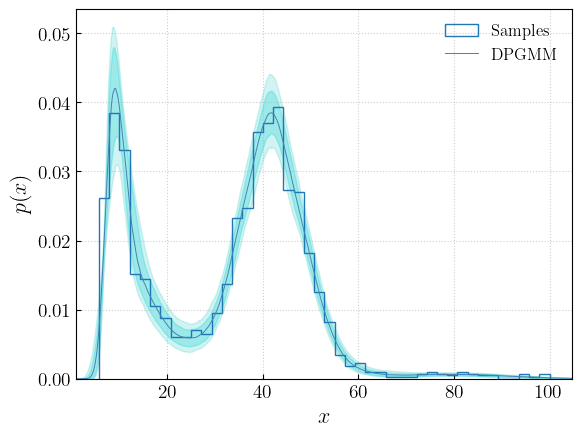

In [4]:
save_density(draws_realistic)

plot_median_cr(draws_realistic, samples=data_realistic, save=True, show=False)